<a href="https://colab.research.google.com/github/ShuYuHuang/CMU_Course_signal/blob/main/04_Medical_Signal/Part_3/1_training_segmentation_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Signal Segmentation 主題簡介

神經網路可以用於醫學訊號分割技術，幫助醫療人員更輕易找到診斷病症的特徵。

例如 ST segmment 切出來以後可以藉由它的slope與area用來評斷 ST Depression 或 ST Elevation，如 Fig.1 所示。

<img src="https://hackmd.io/_uploads/BJC76ohq3.png" height=200>-
*Fig.1: [source](https://link.springer.com/book/10.1007/978-3-031-15816-2)*
> *Paunwala, C. (Ed.). (2022). Biomedical Signal and Image Processing with Artificial Intelligence. Springer.*

因病人的ECG訊號上會有病人個體差異、錄製儀器的差異等等使PQRST波辨識困難，無法用簡單的計算邏輯(取區域最大值，最小值，變化最大/最小等等)定義。

基於神經網路的 Semantic Segmentation (下面簡稱Segmentation) 就可以派上用場，學習並應用於醫學訊號分割。

## 🎡教學目標

- 資料載入: 使用Pytorch訊號分割之Datasets Class準備，包含讀取、前處理等等
- 模型建構: 使用Pytorch建立新的segmentation model結構或者利用已有的結構做訓練 (在醫療訊號上因發展較晚，沒有公認的pre-train model提供遷移學習)，使用Fusionlab套件讀取經典模型架構
- 模型訓練: 使用hugginface transformer 的Trainer 模組訓練模型並調整超參數以達到最佳效果
- 模型評估: 使用開源套件計算評估指標，利用測試資料集評估模型效能


## 🤖模型簡介

在影像或訊號的深度學習其實可以使用同樣類型的模型架構，但其中有些不同之處，就是要降低NN cells的維度，因為影像可以看做是2D的訊號，會多一個維度。

例如將2D convolution轉為1D convolution。而在Signal Segmentation中也是一樣，若將所有牽扯到2D運算的cell換成1D的版本便可操作於訊號上。

這邊教學使用簡單的UNet-based的模型作範例來實作Signal Segmentation。UNet 常拿來處理影像的 segmentation 只要降為 1D 操作 就可以直接套用於 1D 訊號的segmentation。

原本的UNet再複習一下:
1. 其中Encoder由convolution block與pooling 組成，將圖片由大張圖萃取特徵並逐漸downsample成小張圖。
2. Decoder部分則由deconvolution與upsampling組成，將特徵由小張圖漸漸還原成員大小，並得到pixel-wise的標註

<img src="https://hackmd.io/_uploads/B1LEpsh52.png" height=350>-
*Fig.2 : UNet 結構*

若將所有cell置換為 1D 的操作則會如Fig.3所示:
1. 2D convolution -> 1D convolution
2. 2D pooling -> 1D pooling
3. 2D deconvolution -> 1D deconvolution
4. 2D upsample -> 1D upsample

<img src="https://hackmd.io/_uploads/ry646in9n.png" height=350>-
*Fig.3 : 1D UNet 結構*

那不只UNet，若想以其他在影像上的模型套用到其他可能的模型中，也都可以使用較低維度的CNN模型來實作

---

# 資料集介紹

## 📄Lobachevsky University Electrocardiography Database (LUDB)

我們這次用 PQRST segmentation來做為算法應用的例子，資料不多，拿來教學而已。

這筆資料來自於Lobachevsky University，資料內容如下: 參考[官網](https://physionet.org/content/ludb/1.0.1/)
- number of patients: 200
- recordings per patient: 1
- LEADS: 'i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6'
- sampling rate: 500 Hz
- length per record: 10.0 s
- segment annotaion symbols: p(P), N(QRS), t(T)
    - 16797 P waves
    - 21966 QRS complexes
    - 19666 T waves (in total, 58429 annotated waves)

> *Kalyakulina, A. I., Yusipov, I. I., Moskalenko, V. A., Nikolskiy, A. V., Kosonogov, K. A., Osipov, G. V., ... & Ivanchenko, M. V. (2020). LUDB: a new open-access validation tool for electrocardiogram delineation algorithms. IEEE Access, 8, 186181-186190.*

LEAD 排列見Fig.4，為計算出來的虛擬電位。

<img src="https://hackmd.io/_uploads/SkgHaihc2.png" height=300>-
*Fig.4 : [source](https://en.wikipedia.org/wiki/Electrocardiography)*

其Segment annotation 標出ECG中p wave, n wave, t wave整個complex波形而不是只有頂點，這樣可以多些可判讀訊息，例如QRS complex出現的長度

<img src="https://hackmd.io/_uploads/Sk4B6in5h.png" height=300>-
*Fig.5 LUDB資料標註形式*

訊號在數字上表現如下，以QRS波形出現為例，沒有波形時標註為0，QRS波形(N)標為2

## 🗃️資料載入

訊號有各種讀法，光在ECG訊號上就有各種格式，以致於甚至有人特別開始做了[轉檔的生意](https://www.amps-llc.com/Services/ecg-file-format-conversion)。

這次我們的目標儀器是 [GE 的 MUSE ECG系列](https://www.gehealthcare.com/products/diagnostic-ecg/muse-nx)。原始檔使用XML格式做檔案儲存 - *.xml，不過網路上並沒有留存開源的MUSE系列原檔，都是經轉換成其他格式。退而求其次，為找到相同儀器收錄的資料，我們在巨量醫學資料庫 [PhysioNet](https://physionet.org/) 上找到一些用 MUSE ECG 錄的資料集、其中有下列常見資料格式:

- PhysioNet 出的 WFDB 格式
    - 資料檔 *.dat 或 *.edf 或 *.wav 紀錄資料本身
    - 標頭檔 *.hea 紀錄meta data，包含患者資訊以及收錄器材資訊
    - 使用 [WFDB](https://wfdb.readthedocs.io/en/latest/) toolbox 讀取
- CSV格式
    - 資料檔 *.csv，
    - 附上無標準格式的 meata data 紀錄，包含患者資訊以及收錄器材資訊
    - 可以使用 [pandas](https://pandas.pydata.org/) 讀取或者使用 [numpy.genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html) 讀取



這邊使用 AIA 開發的醫療 AI 影像/訊號工具包 fusionlab 並提供LUDB的讀取方式將之包裝成Dataset object，可以讓使用者直接下載->檢查->讀取資料。

In [1]:
# 安裝 fusionlab，使用AIA提供的各種訓練輔助功能
%pip install git+https://github.com/ShuYuHuang/ai4ecg.git

# 安裝transformers以便進行訓練
%pip -q install transformers==4.30.0 accelerate

  Cloning https://github.com/ShuYuHuang/ai4ecg.git to /tmp/pip-req-build-r0qcl8cv
  Running command git clone --filter=blob:none --quiet https://github.com/ShuYuHuang/ai4ecg.git /tmp/pip-req-build-r0qcl8cv
  Resolved https://github.com/ShuYuHuang/ai4ecg.git to commit b6bee0d39a92ca826d16b3b89cce30ea2861d07b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 478.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 15.7 MB/s eta 0:00:00
  Created wheel for fusionlab: filename=fusionlab-0.1.5-py3-none-any.whl size=68383 sha256=16e841a58e70226deca7e713c4dbc2e72b61699c27ef59196f0ea8fe476642f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-wo56imiz/wheels/11/5b/42/0b03a103fee733901f7d6cdc6d6381fa6685adf465f3d488f9
Successfully built fusionlab
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
from fusionlab.datasets import ludb  # fusionlab 處裡data相關模組
from os.path import join  # 將路徑合併、完成

DATA_DIR = "data"
# 定義資料路徑、標註路徑
ANNOTATION_PATH = join(DATA_DIR,'ludb_annotation.json')

# 下列動作透過fusionlab.datasets.ludb.LUDBDataset一建完成
# 1. 下載檔案到指定位置 (data_dir)
#    若已下載則不會再下載一次
# 2. 將其中 channel I 的標註內容轉換成 segment marks
# 3. segmnet marks 存成 json 檔
# 4. 建立torch Dataset object, 使後續可以用於hugginface Trainer 訓練segmentation model
# 5. 讀取時讀取1.282秒至7.992秒之間的訊號，因為1.282秒前與7.992秒後因系統關係沒有標註

ds = ludb.LUDBDataset(
    data_dir=DATA_DIR,
    annotation_path=ANNOTATION_PATH)


Start downloading the dataset from https://physionet.org/static/published-projects/ludb/lobachevsky-university-electrocardiography-database-1.0.1.zip to data/LUDB.zip


100%|██████████| 14474484/14474484 [00:24<00:00, 599181.16it/s]


Extracting data/LUDB.zip to data
Start processing annotation file and save to data/ludb_annotation.json


  0%|          | 0/200 [00:00<?, ?it/s]

### 觀察Meta Data

In [3]:
# 通常資料集會附一些 information 幫助做資料內容判讀
# LUDB 中附一個 information 紀錄病人資料

import pandas as pd

# 此檔案連同LUDB一起下載
INFO_PATH = join(DATA_DIR,'lobachevsky-university-electrocardiography-database-1.0.1/ludb.csv')

info = pd.read_csv(INFO_PATH)
info = info.fillna("NONE")
print("Number of subjects:",len(info))

Number of subjects: 200


In [4]:
# 隨機挑幾個來看資料型式
# 只是讓自己後續較清楚內容而已
# 我們這邊重點還是 signal 的處裡
info.sample(3)

,ID,Sex,Age,Rhythms,Electric axis of the heart,Conduction abnormalities,Extrasystolies,Hypertrophies,Cardiac pacing,Ischemia,Non-specific repolarization abnormalities,Other states
123,124,M\n,66\n,Sinus rhythm,Electric axis of the heart: left axis deviation,NONE,NONE,Left atrial overload\nLeft ventricular hypertr...,NONE,NONE,Non-specific repolarization abnormalities: lat...,NONE
182,183,M\n,63\n,Sinus rhythm,Electric axis of the heart: left axis deviation,NONE,NONE,Left atrial hypertrophy\nLeft atrial overload\...,NONE,Undefined ischemia/scar/supp.nstemi: posterior...,NONE,NONE
10,11,M\n,54\n,Sinus rhythm,Electric axis of the heart: left axis deviation,NONE,NONE,Left atrial hypertrophy\nLeft ventricular hype...,NONE,Undefined ischemia/scar/supp.nstemi: inferior ...,NONE,NONE


<Axes: >

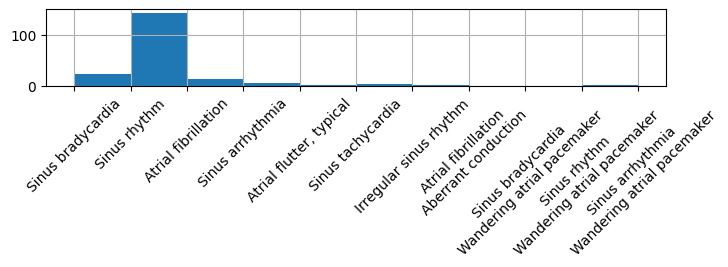

In [5]:
# 看一下各項的比例，可自由變化項目觀看，這邊僅先示範一個，可以替換下表內容使用
#
#  'Sex', 'Age', 'Rhythms', 'Electric axis of the heart', 'Conduction abnormalities',
#  'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 'Ischemia', 'Non-specific repolarization abnormalities', 'Other states'
info['Rhythms'].hist(xrot=45,figsize=(8,1))

多看幾個就可以看到說其實NONE的比較多，占比不均的病症類型還是有幾個。

完整報告可以看[官網](https://physionet.org/content/ludb/1.0.1/)，若真因為病症樣本不均導致訓練效果不佳可以再回頭調整病症被抽選的比例。

### 若需要標註則須經過資料轉換

In [6]:
# Save the file in .csv for inspection
import numpy as np
idx = 1
data = ds.get_signal(ds.signal_dir,idx)
frame = pd.DataFrame(data, columns =['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6'])
frame.insert(0,'time',np.linspace(0.,10.-1/500,5000))
frame.to_csv(f'{idx}.csv',index=False)

這邊示範將signal檔案轉至需求的格式，轉成此格式可以使用label-studio做標籤修正等等，給各位做參考

當然若是用label-studio做標籤會需要使用/設計其他Data loader

### 觀察載入資料

拿到資料可以先隨手抽幾個人來觀察一下，我們有附上LUDB

In [7]:
# split train/test
from sklearn.model_selection import train_test_split
train_ds, val_ds = train_test_split(ds, test_size=0.2, random_state=100)

In [8]:
# 可以用fusionlab附屬的signal segmentation畫圖小工具 ludb.plot 畫出來看看
# X軸 - 經過re-center, 只留原本1.282秒至7.992秒之間訊號
# Y軸 - 針對任一channel進行觀察，Typical QRS complex大概 1-3 mV
#       這邊有用standard deviation normalize過
%matplotlib inline
from random import randint
for _ in range(2):
    i = randint(0, len(ds) - 1)
    print(f"Patient {ds.file_ids[i]}, with records:")
    print(info.iloc[ds.file_ids[i]-1]) # 這邊dataset的編號要跟info檔的編號對一下
    print("------")
    x, y = ds[i]
    ludb.plot(x, y, channel='v1')

Patient 17, with records:
ID                                                                                          17
Sex                                                                                        F\n
Age                                                                                       71\n
Rhythms                                                                           Sinus rhythm
Electric axis of the heart                                  Electric axis of the heart: normal
Conduction abnormalities                                                                  NONE
Extrasystolies                                                                            NONE
Hypertrophies                                Left atrial hypertrophy\nRight ventricular hyp...
Cardiac pacing                                                                            NONE
Ischemia                                                                                  NONE
Non-specific repolarizat

Patient 61, with records:
ID                                                                                          61
Sex                                                                                        M\n
Age                                                                                       58\n
Rhythms                                                                           Sinus rhythm
Electric axis of the heart                     Electric axis of the heart: left axis deviation
Conduction abnormalities                                                     I degree av block
Extrasystolies                                                                            NONE
Hypertrophies                                Left atrial hypertrophy\nLeft ventricular hype...
Cardiac pacing                                                                            NONE
Ischemia                                     Undefined ischemia/scar/supp.nstemi: apical\nU...
Non-specific repolarizat

稍微看一下，data 的時間點沒有align，

In [8]:
# 另外還有工具可以指定繪畫的channels, 將這些channels 垂直排列觀看
i = randint(0, len(ds) - 1)
x, y = ds[i]
print(f"Patient {ds.file_ids[i]}, with records:")
print(info.iloc[ds.file_ids[i]-1])
print("------")
ludb.plot_leads(x, y, channels=['v1','v2','v3','v4','v5','v6'])

Patient 84, with records:
ID                                                                                          84
Sex                                                                                        M\n
Age                                                                                       79\n
Rhythms                                                                           Sinus rhythm
Electric axis of the heart                     Electric axis of the heart: left axis deviation
Conduction abnormalities                                               Left anterior hemiblock
Extrasystolies                                                                            NONE
Hypertrophies                                                          Left atrial hypertrophy
Cardiac pacing                                                                            NONE
Ischemia                                     Ischemia: inferior wall\nUndefined ischemia/sc...
Non-specific repolarizat

In [9]:
# 我們要做機器學習，可以稍微看一下 label distribution
NUM_LABELS = 4

label_counts = {
    x: 0 for x in range(NUM_LABELS)
}
for data, labels in ds:
    for y in labels:
        label_counts[int(y)] += 1
print("Ratio of labels",label_counts)

Ratio of labels {0: 406474, 1: 60596, 2: 71759, 3: 133171}


顯然這是一個label也不太平衡的訓練集，但沒關係，往常segmentation task都是不平衡的

**Q:**
你能說出幾種對抗不平衡的方式呢? 有沒有針對 segmentation 做的 balencing 方案? (提示: 一種 loss)

---

# 模型建立

我們持續使用 hugginface 當作高級框架，以下看到HF則為hugginface的簡稱。

那目前並沒有使用 1D convolution 來做Large dataset pretraining，所以沒有pre-train model可用，未來HF或許能開放一些更通
用的內容，但可惜目前還沒有。

可以關注 HF 中 Time series transformer 的文件
- https://huggingface.co/docs/transformers/v4.23.0/en/model_doc/time_series_transformer

亦可以在 HF 搜尋引擎中搜尋，但目前只有一些非常特定主題的pre-train model:
- e.g. [每月遊客資料](https://huggingface.co/huggingface/time-series-transformer-tourism-monthly)，"huggingface/time-series-transformer-tourism-monthly"
- e.g. [Nixtla: 試做Transfer Learning](https://huggingface.co/spaces/Nixtla/transfer-learning-time-series), 無hf讀取

## Fusionlab Segmentation model

AIA 提供簡單的工具build model，其中為了使用 HF Trainer以及其他功能，我們提供 HF wrapper，將任意pytorch model 包裝成 hugginface 格式。

AIA Fusionlab中的segmentation這個模組包含了幾種經典的 UNet based segmentation model:
- UNet: 最早的Unet，用concatenation連接encoder及decoder
    - ResUNet: 加入Residual connection block的Unet
    - UNet++: 在connection上增加Units 連接的Unet

這些Model可以藉由簡單的 argument 決定 convolution 的 dimension ，可以使用 1D~3D convolution based segmentation。


In [10]:
# 這邊範例使用ResUNet,
from fusionlab.segmentation import ResUNet
NUM_LABELS = 4
model = ResUNet(cin=12, num_cls=NUM_LABELS, base_dim=64, spatial_dims=1)

In [11]:
# 我們也提供function 方便查詢 model 對其他模型的繼承
# 若在網路上看到其他模型也可以將它們的繼承關係列出，方便更完整的查找使用方式
from fusionlab.utils import show_classtree
show_classtree(ResUNet)

<class 'fusionlab.segmentation.resunet.resunet.ResUNet'> | input: ['self', 'cin', 'num_cls', 'base_dim', 'spatial_dims']
      <class 'fusionlab.segmentation.base.SegmentationModel'> | input: ['self', '*args', '**kwargs']
            <class 'torch.nn.modules.module.Module'> | input: ['self', '*args', '**kwargs']
                  <class 'object'> | input: []


In [12]:
# 對於模型結構，我們可以直接使用call model object來看
model

ResUNet(
  (encoder): Encoder(
    (stem): Stem(
      (conv): Sequential(
        (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (skip): Sequential(
        (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (stage1): ResConv(
      (conv): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (skip): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1):

## Fusionlab model wrapper for hugginface trainer

為求通用性，fusionlab設計model為普通的torch model，可以用於各種自訂義的訓練

若要方便 HF 的Trainer使用，必須符合 HF Model 的格式要求:

1. Input argument names: 輸入包含 data 及 label
    - input data 名稱必須要與dataloader相對應 (此處我們設為"x")，並且要有"labels"這個input
    - labels 可以不輸入沒關係，但要有這 argument 存在，因此 default 為 None
2. Output: 輸出算出來的loss 以及 output logits (模型輸出端輸出的數字)
    - 必須為dictionary，且含有"loss", "logits" 兩個key
    - Model object必須包含計算loss的功能，且在 forward 時若有 label 要計算loss

其餘逐繁不及備載，但以上幾點對於要訓練、驗證、推論綽綽有餘，

我們已經將以上功能包成一個 class，輸入model以及 loss function 就可以將原本的 model 打包成 HF model

In [13]:
# 讀取HF wrapper
from fusionlab.segmentation import HFSegmentationModel

# Hugginface model 需含有loss function，這邊我們的model可先指定好
from fusionlab.losses import DiceLoss

# wrap model into HF model
model_hf = HFSegmentationModel(model, loss_fct=DiceLoss())

# 模型訓練

有模型及資料準備開始訓練

## Fusionlab dataset wrapper for huggingface trainer

配合HF trianer，將dataset也做wrapping，同樣要符合幾個格式需求
- 需要可以 index，即 dataset_hf[0]、dataset_hf[1] 等等必須存在
- 需要有長度，即 必須能計算 len(dataset_hf)
- Output: 以dictionary 形式輸出 data 及 labels
    - 名稱需與HF Model對應，此處設為 {"x": data, "labels": labels}

這邊在AIA fusionlab也提供相應包裝功能

In [14]:
# wrap them into HF dataset
from fusionlab.datasets.utils import HFDataset
train_ds_hf = HFDataset(train_ds)
val_ds_hf = HFDataset(val_ds)

## 訓練參數

Hugginface的Trainer模組可以讓不同類型的訓練套用類似的訓練設定，將過去的訓練活用在未來的訓練上

同時列表化的 arguments 也方便各種實驗進行。

下面解說幾種常用參數類型:

1. 訓練參數相關(主要做ablation study會調控的參數):
    - per_device_train_batch_size: 每個裝置訓練的Batch size, Hugginface分散式運算每個GPU的batch大小
    - learning_rate: 學習率
    - weight_decay: L2 normalization 比率，使weight不至於變化太大
2. 訓練內容評估:
    - num_train_epochs: EPOCH數
    - evaluation_strategy: 多久評估一次，有 'no'、'epoch'、'step'可選，若選step必須指定eval_steps
3. 模型儲存
    - save_strategy: 多久儲存一次，有 'no'、'epoch'、'step'可選，若選step必須指定save_steps
    - save_total_limits: 最多存幾個 model ，請設定以避免硬碟空間爆掉
    - metric_for_best_model: 決定最佳模型的計算指標，通常是loss或eval_loss，越小越好
    - load_best_model_at_end: 是否在訓練結束時載入最佳模型
4. 輸出內容設定
    - output_dir: 輸出目錄
    - overwrite_output_dir: 是否覆蓋已有目錄及內容
    - logging_steps: 紀錄訓練內容的步數(每X步記錄一次)
5. 其他:
    - remove_unused_columns: 是否刪除沒用到的模型forward輸出值(key+value)，若設為 True 常會使一些判斷項無法運作

In [18]:
from transformers import TrainingArguments  # 匯入所需套件
OUTPUT_DIR = 'history' # 設定輸出目錄
training_args = TrainingArguments( # 設定訓練參數
    per_device_train_batch_size=4, # 設定每個裝置的訓練批次大小
    learning_rate=1e-4, # 設定學習率
    weight_decay=1e-5, # 設定權重衰減率

    num_train_epochs=10, # 設定訓練的 Epoch 數量
    evaluation_strategy='epoch', # 設定評估策略

    save_strategy='epoch', # 設定儲存策略
    save_total_limit=2, # 設定最多儲存模型的數量
    metric_for_best_model='eval_loss', # 設定最佳模型的評估指標
    load_best_model_at_end=True, # 是否在訓練結束時載入最佳模型

    output_dir=OUTPUT_DIR, # 設定輸出目錄
    overwrite_output_dir=True, # 是否覆蓋輸出目錄中的檔案
    logging_steps=5, # 設定記錄日誌的步數
    remove_unused_columns=False, #(重要)需設為False，否則會報錯
)

## Trainer物件

接下來組建模型Trainer object，可以拿來train模型、evaluate、inference。

其中需要代入一些object來initiate這個trainer object。
- model: 必須要式HF model
- args: 剛剛的TrainingArguments object
- train_dataset: 訓練集，HF dataset物件
- eval_dataset: 驗證集，HF dataset物件
- compute_metrics: 評估指標function，可加可不加，若不加則記錄 loss 跟 eval_loss 而已

In [19]:
# compute metrics樣本，輸入為prediction output
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    global NUM_LABELS
    labels = pred.label_ids # label化為class選項，0 ~ NUM_LABELS-1
    preds = pred.predictions.argmax(1)
    acc = accuracy_score(labels.reshape(-1), preds.reshape(-1))
    return {
        'acc': acc
    }

In [20]:
from transformers import Trainer
trainer = Trainer( # 建立 Trainer 物件
    model=model_hf, # 模型物件
    args=training_args, # 訓練參數物件
    train_dataset=train_ds_hf, # 訓練資料集物件
    eval_dataset=val_ds_hf, # 驗證資料集物件
    compute_metrics=compute_metrics,
)
trainer.train() # 開始訓練模型

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epoch,Training Loss,Validation Loss,Acc
1,0.345200,0.533096,0.686057
2,0.289800,0.344128,0.718460
3,0.258200,0.296331,0.775439
4,0.253500,0.246160,0.821533
5,0.197400,0.221202,0.841168
6,0.221400,0.206296,0.855685
7,0.151600,0.192540,0.861801
8,0.204300,0.187670,0.863787
9,0.162300,0.186031,0.866600
10,0.166700,0.182008,0.868594


TrainOutput(global_step=400, training_loss=0.24012929916381837, metrics={'train_runtime': 24.3874, 'train_samples_per_second': 65.608, 'train_steps_per_second': 16.402, 'total_flos': 0.0, 'train_loss': 0.24012929916381837, 'epoch': 10.0})

In [21]:
# a.讀取best model-
trainer._load_best_model()

# b.讀取指定model
# trainer._load_from_checkpoint('history/checkpoint-XXX') # checkpoint-XXX請改為儲存的checkpoint資料夾名稱

In [22]:
# Trainer object可以拿來做inference
# 可省去以下步驟: batching, to gpu, no_grad, calculate metric,

pred = trainer.predict(val_ds_hf, ignore_keys=['hidden_states'])

In [23]:
pred.label_ids.shape

(40, 3360)

In [24]:
dl = trainer.get_test_dataloader(val_ds_hf)

In [25]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
def dice_coefficient(pred, y):
    import numpy as np
    """
    Compute the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    pred : array-like, bool
        Predicted labels, as returned by a classifier.
    y : array-like, bool
        True labels.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Higher is better.
    """
    y = F.one_hot(y, num_classes=NUM_LABELS).transpose(-1,-2)
    # Compute Dice coefficient
    if pred.shape != y.shape:
        raise ValueError("Shape mismatch: pred and y must have the same shape.")
    pred = np.asarray(pred).astype(np.bool)
    y = np.asarray(y).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(pred, y)

    return 2. * intersection.sum() / (pred.sum() + y.sum())

dl = DataLoader(val_ds, batch_size=4, shuffle=False)
dice_total = []

with torch.no_grad():
    for x, y in dl:
        pred = model(x.cuda()).cpu().detach()
        dice_total.append(dice_coefficient(pred,y))

<ipython-input-25-af5313d8c883>:24: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-25-af5313d8c883>:25: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

